In [1]:
import numpy as np 
import pandas as pd 
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from subprocess import check_output
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

C:\Users\Mimi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#import csv data 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

* Check for missing data and data types 

* Check number of columns and rows for both train and test set

In [3]:
#train data 
print (train.info())
#test  data 
print (test.info())
#shape of training set (1458644,11)
#shape of test set (625134,9)
#no missing value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      6

In [4]:
#see value of vendor_id
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [5]:
#check of id is unique
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('Id is not unique, Please check')

Id is unique.


In [6]:
#find out that 'store_and_fwd_flag' has only 2 values
print (train['store_and_fwd_flag'].value_counts())
print (test['store_and_fwd_flag'].value_counts())

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64
N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64


In [7]:
#replace categorical data with continuous data 
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':0,'Y':1}).astype(np.int)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N':0,'Y':1}).astype(np.int)

## Check target variable

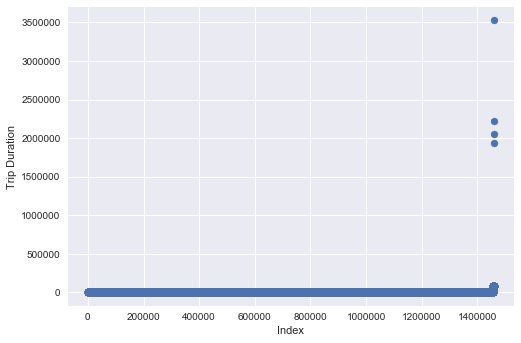

In [8]:
plt.scatter(range(train.shape[0]),np.sort(train['trip_duration']))
plt.xlabel('Index')
plt.ylabel('Trip Duration')
plt.show()

# Applying log transformation
Not sure whether test set will have unusual trip duration or not. Applying log transformation will cause less trouble when there are outliers.

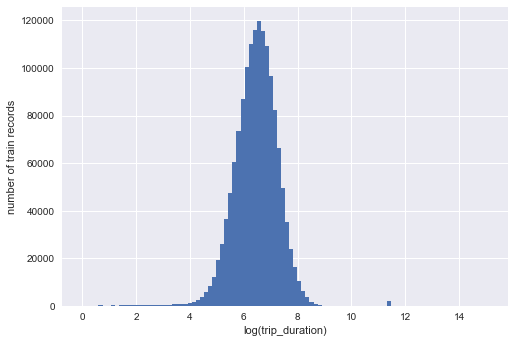

In [9]:
# #remove outliers of target variable
# train_new = train[train.trip_duration < 500000]

# apply log to 'trip duration'
train['trip_duration_log'] = train['trip_duration'].apply(np.log)
plt.hist(train['trip_duration_log'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Check train test split 
In this case the train and test split seems to be random since the area is complete overlapped. This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

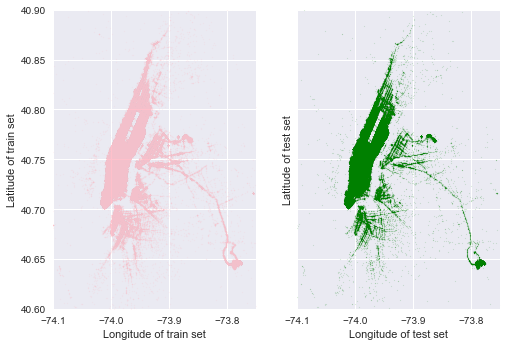

In [10]:
#coordinate of NYC 40.7128° N, 74.0059° W
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
long_border = (-74.1, -73.75)
lat_border = (40.6, 40.9)
plt.ylim(lat_border)
plt.xlim(long_border)
ax[0].set_xlabel('Longitude of train set')
ax[0].set_ylabel('Latitude of train set')
ax[1].set_xlabel('Longitude of test set')
ax[1].set_ylabel('Latitude of test set')

ax[0].scatter(train['pickup_longitude'],train['pickup_latitude'],color='pink',s=1,alpha=0.1)
ax[1].scatter(test['pickup_longitude'],test['pickup_latitude'],color='green',s=1,alpha=0.1)
plt.show()

# Feature Extraction

## Applying PCA
PCA from 2D to 2D , This is not about dimension reduction,rotating plane of latitude and longitude coordinates could help trees to split better.

In [11]:
#fit PCA to pickup and dropoff lat lng
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
#apply pca to both train and test pickup / dropoff lat lon
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

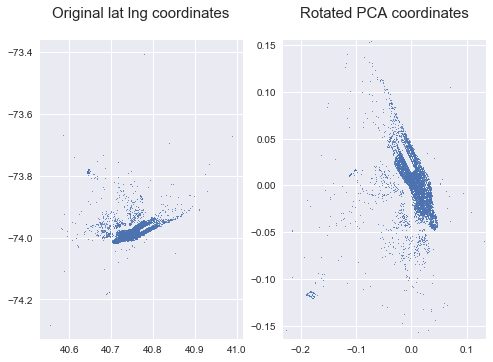

In [12]:
#plot original lat lng and rotated PCA
#transform PCA to all coordinate
X_pca = pca.transform(coords)
_, (ax1, ax2) = plt.subplots(1,2)

sample_ind = np.random.permutation(len(coords))[:10000]
ax1.scatter(coords[sample_ind,0], coords[sample_ind,1], s=1, lw=0)
ax1.set_title('Original lat lng coordinates\n',size=15)

ax2.scatter(X_pca[sample_ind,0], X_pca[sample_ind,1], s=1, lw=0)
ax2.set_title('Rotated PCA coordinates\n',size=15)
#set xlim and ylim to NYC border
pca_borders = pca.transform([[x, y] for x in lat_border for y in long_border])
ax2.set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax2.set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

## Find distance from latitude and longitude coordinate

In [13]:
#find distance from lat long
from math import radians, cos, sin, asin, sqrt
def haversine_np(lat1, lng1, lat2, lng2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    earth_radius = 6371 # in km
    lng1, lat1, lng2, lat2 = map(np.radians, [lng1, lat1, lng2, lat2])

    dlng = lng2 - lng1
    dlat = lat2 - lat1
    distance = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2.0)**2

    km = earth_radius * 2 * np.arcsin(np.sqrt(distance))
    return km

def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_np(lat1, lng1, lat1, lng2)
    b = haversine_np(lat1, lng1, lat2, lng1)
    return a + b

In [14]:
#apply distance to dataset
train.loc[:, 'distance_haversine'] = haversine_np(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_manhattan'] = manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_np(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_manhattan'] = manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

#define center lat long from pickup and dropoff coordinates
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

## Date Time features
Month and day of week can be quite useful in understanding periodicity or seasonality of data. We may find that some actions are more probable on certain days of the week, or somethings happen around the same month every year. 

In [15]:
#extract pickup_datetime to weekday,month,hour,minutes

#train set
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_month'] = train['pickup_datetime'].dt.month

train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

#test set
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test.loc[:,'pickup_month'] = test['pickup_datetime'].dt.month
test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

# Data Understanding 

### Get speed from distance haversine and manhattan
Look at speed to see the traffic profile on each date and time.

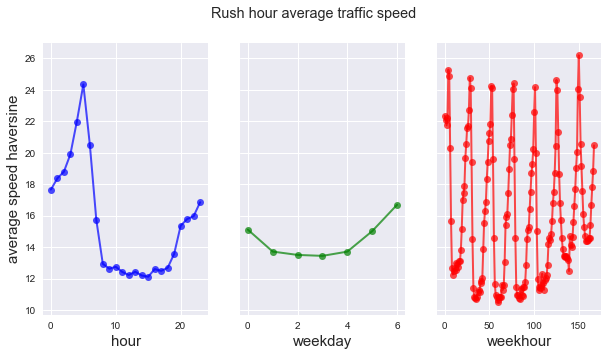

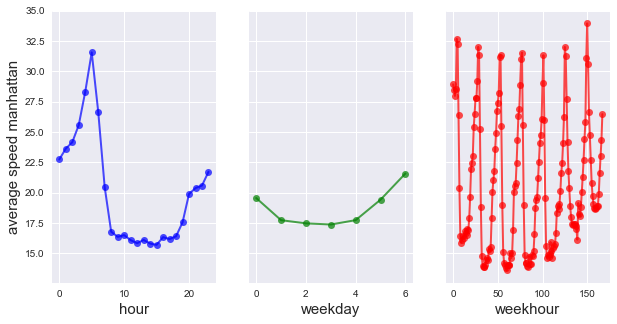

In [16]:
train.loc[:, 'speed_h'] = 3600 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'speed_m'] = 3600 * train['distance_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(10,5))
ax[0].plot(train.groupby('pickup_hour').mean()['speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['speed_h'], 'ro-', lw=2, alpha=0.7)

ax[0].set_xlabel('hour',size=15)
ax[1].set_xlabel('weekday',size=15)
ax[2].set_xlabel('weekhour',size=15)
ax[0].set_ylabel('average speed haversine',size=15)

fig.suptitle('Rush hour average traffic speed')

fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(10,5))
ax[0].plot(train.groupby('pickup_hour').mean()['speed_m'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['speed_m'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['speed_m'], 'ro-', lw=2, alpha=0.7)

ax[0].set_xlabel('hour',size=15)
ax[1].set_xlabel('weekday',size=15)
ax[2].set_xlabel('weekhour',size=15)
ax[0].set_ylabel('average speed manhattan',size=15)
plt.show()

### Look at histogram for the month
There is an overlap of months for train/test set so the month feature will be useful

3    109697
5    107570
4    107432
2    102314
6    100445
1     97676
Name: pickup_month, dtype: int64


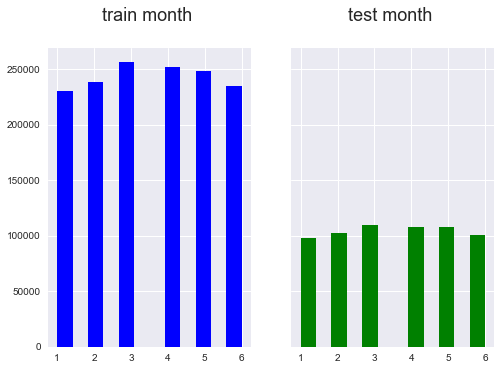

In [17]:
print (test.pickup_month.value_counts())

fig,ax = plt.subplots(ncols=2,sharex=True, sharey=True)
ax[0].hist(train.pickup_month,12,color='blue')
ax[1].hist(test.pickup_month,12,color='green')
ax[0].set_title('train month \n',size=18)
ax[1].set_title('test month \n',size=18)

plt.show()

### Look at average trip duration by hour of day and day of week

Over the course of a typical day we find a peak in the early afternoon and dips around 5-6am and 8pm. 
The weekday and hour of a trip appear to be important features for predicting its duration and should be included in a successful model.

In [18]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,center_longitude,pickup_weekday,pickup_month,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,speed_h,speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,-73.973392,0,3,11,17,24,6369878.0,17,11.856428,13.730901
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,-73.989948,6,6,23,0,43,14085798.0,144,9.803659,13.197318
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,-73.992180,1,1,3,11,35,1596907.0,35,10.822201,13.904365
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,-74.011154,2,4,14,19,32,8364734.0,67,12.465721,13.941241
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,-73.972988,5,3,12,13,30,7392638.0,133,9.836594,9.926539


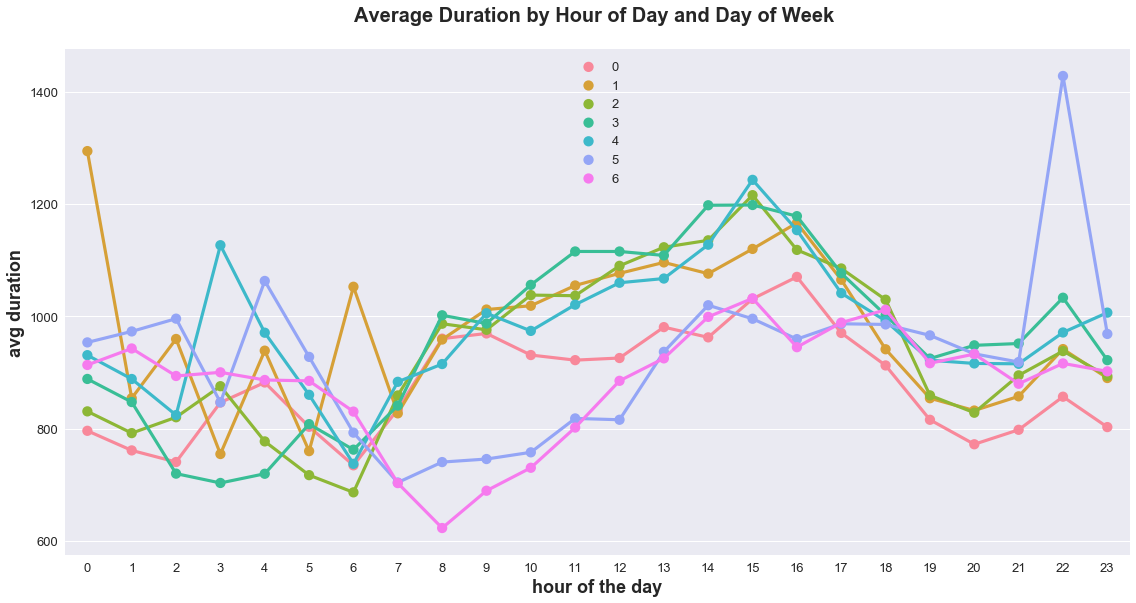

In [19]:
#plot trip duration profile by hour of day and each day of week.
sns.set(font_scale=1.3)
g = sns.factorplot('pickup_hour', 
                   'trip_duration', 
                   hue = 'pickup_weekday', 
                   estimator = np.mean, 
                   data = train, 
                   size = 8, 
                   aspect=2,
                    ci=None,
                   legend_out=False)
sns.plt.title('Average Duration by Hour of Day and Day of Week \n',weight='bold', size = 20)
plt.xlabel('hour of the day', size = 18, weight = 'bold')
plt.ylabel('avg duration', size = 18, weight = 'bold')
plt.legend()

# Find feature related to target
There is a similar pattern as for the business of the day of the week. Vendor 2, the one with the more frequent trips, also has consistently higher trip durations than vendor 1. It will be worth adding the vendor_id feature to a model to test its predictive importance.


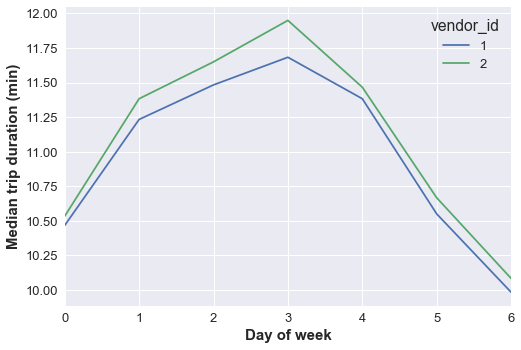

In [20]:
#check pickup datetime VS trip duration
#variation in trip numbers throughout the day and the week affect the average trip duration?

for index, group in train.groupby(['vendor_id']):
    group_agg = group.groupby(['pickup_weekday'])['trip_duration'].aggregate(np.median)
    group_agg = group_agg / 60
    group_agg.plot(x ='Day of week', y='Median trip duration (min)', label=index)
    plt.xlabel('Day of week', size=15, weight='bold')
    plt.ylabel('Median trip duration (min)', size=15, weight='bold')
    plt.legend(title='vendor_id')

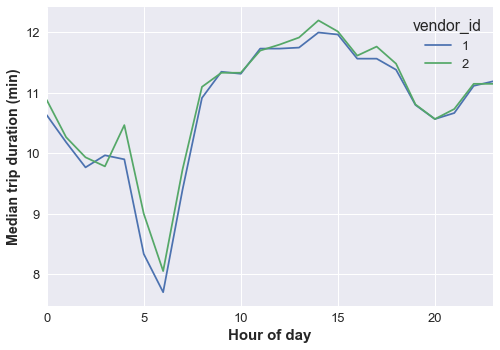

In [21]:
for index, group in train.groupby(['vendor_id']):
    group_agg = group.groupby(['pickup_hour'])['trip_duration'].aggregate(np.median)
    group_agg = group_agg / 60
    group_agg.plot(x = 'Hour of day', y = 'Median trip duration (min)', label=index)
    plt.xlabel('Hour of day',size=15,weight='bold')
    plt.ylabel('Median trip duration (min)',weight='bold')
    plt.legend(title='vendor_id')

### Passenger count and vendor VS trip duration
Comparing the densities of the trip_duration distribution for the two vendors we find that the medians are very similar, 
whereas the means are likely skewed by vendor 2 containing most of the long-duration outliers:

In [22]:
#check passenger count and vendor vs trip duration
trip1 = train.groupby(['vendor_id'])['trip_duration'].median().reset_index(name='median_duration')
trip2 = train.groupby(['vendor_id'])['trip_duration'].mean().reset_index(name='mean_duration')
trip = pd.merge(trip1, trip2, how='inner',on=['vendor_id'])
trip

,vendor_id,median_duration,mean_duration
0,1,658,845.438244
1,2,666,1058.643164


### Store and forward VS trip duration
We find that there is no large differences between the stored and non-stored trips.
The stored ones might be slightly longer and don’t include any of the suspiciously long trips.

In [23]:
train.groupby(['vendor_id','store_and_fwd_flag'])['store_and_fwd_flag'].count().reset_index(name='count_store_and_fwd')

,vendor_id,store_and_fwd_flag,count_store_and_fwd
0,1,0,670297
1,1,1,8045
2,2,0,780302


### Reference for lat lon decimal places
in kilometers : https://en.wikipedia.org/wiki/Decimal_degrees

in miles : https://lightmanufacturingsystems.com/heliostats/support/decimal-latitude-longitude-accuracy/

# Clustering
Cluster trips in order to aggregate information about them.

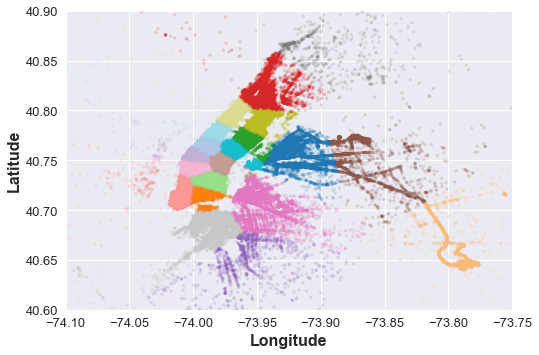

In [24]:
#Randomly permute a sequence
n_clusters=20
batch_size=10000
sample_ind = np.random.permutation(len(coords))[:600000]
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#plot cluster
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=10, lw=0,
           c=train.pickup_cluster.values, cmap='tab20', alpha=0.2)
ax.set_xlim(long_border)
ax.set_ylim(lat_border)
ax.set_xlabel('Longitude',size=16,weight='bold')
ax.set_ylabel('Latitude',size=16,weight='bold')
plt.show()

## Plot number of cluster VS trip duration

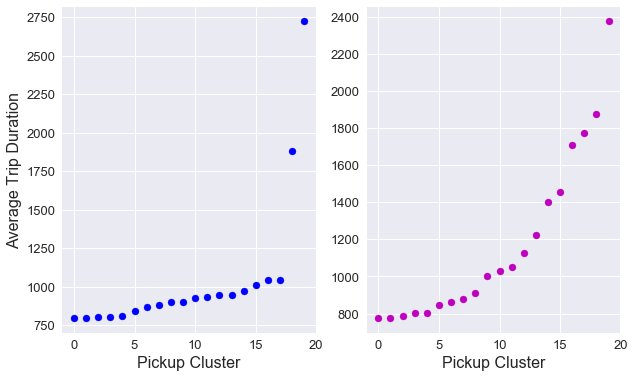

In [25]:
pickupClust = train.groupby(['pickup_cluster'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'mean_trip'}).sort_values('mean_trip').reset_index()
dropoffClust = train.groupby(['dropoff_cluster'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'mean_trip'}).sort_values('mean_trip').reset_index()
fig,ax = plt.subplots(ncols=2,figsize=(10,6))
ax[0].scatter(pickupClust.index,pickupClust.mean_trip,color='b')
ax[0].set_xlabel('Pickup Cluster',size=16)
ax[0].set_ylabel('Average Trip Duration',size=16)
ax[1].scatter(dropoffClust.index,dropoffClust.mean_trip,color='m')
ax[1].set_xlabel('Dropoff Cluster',size=16)

In [26]:
# Count how many trips are going from each cluster over time
count_pick_train = train.set_index(['id']).groupby(['pickup_cluster'])['pickup_cluster']\
                .transform('count').reset_index().rename(columns={'pickup_cluster':'pickup_cluster_count'})
count_pick_test = test.set_index(['id']).groupby(['pickup_cluster'])['pickup_cluster']\
                .transform('count').reset_index().rename(columns={'pickup_cluster':'pickup_cluster_count'})

# Count how many trips are going to each cluster over time
count_drop_train = train.set_index(['id']).groupby(['dropoff_cluster'])['dropoff_cluster'].transform('count').reset_index().rename(columns={'dropoff_cluster':'dropoff_cluster_count'})
count_drop_test = test.set_index(['id']).groupby(['dropoff_cluster'])['dropoff_cluster'].transform('count').reset_index().rename(columns={'dropoff_cluster':'dropoff_cluster_count'})

# merge number of trips from each cluster to train and test
train = pd.merge(train,count_pick_train, on='id',how='left')
train = pd.merge(train,count_drop_train, on='id', how='left')

test = pd.merge(test,count_pick_test, on='id',how='left')
test = pd.merge(test,count_drop_test, on='id', how='left')

# Include OSRM

In [27]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv')
fr2 = pd.read_csv('fastest_routes_train_part_2.csv')
test_street_info = pd.read_csv('fastest_routes_test.csv')
train_street_info = pd.concat((fr1, fr2))
# train = train.merge(train_street_info, how='left', on='id')
# test = test.merge(test_street_info, how='left', on='id')
# train_street_info.head()

In [28]:
fr1.head(3)

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."


In [29]:
feature_osrm = ['id','total_distance','total_travel_time','number_of_steps']
train_street_info = train_street_info[feature_osrm]
test_street_info = test_street_info[feature_osrm]
train = pd.merge(train,train_street_info, how='left', on='id')
test = pd.merge(test,test_street_info, how='left', on='id')

In [30]:
a = train
nan_rows = pd.DataFrame(a[a.isnull().any(1)])
#print nan_rows to see id and there's NaN in data
print (nan_rows)
#drop NaN row
train = train.drop(train[train.id == 'id3008062'].index)

                id  vendor_id     pickup_datetime    dropoff_datetime  \
1133561  id3008062          2 2016-06-23 19:04:09 2016-06-23 19:04:35   

         passenger_count  pickup_longitude  pickup_latitude  \
1133561                1        -73.787537         40.64241   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
1133561         -73.787811         40.642109                   0   

              ...         pickup_week_hour   speed_h   speed_m  \
1133561       ...                       91  5.641249  7.848513   

         pickup_cluster  dropoff_cluster  pickup_cluster_count  \
1133561               3                3                 33130   

         dropoff_cluster_count  total_distance  total_travel_time  \
1133561                  17673             NaN                NaN   

         number_of_steps  
1133561              NaN  

[1 rows x 36 columns]


## Select training features for feeding in model

In [31]:
# which columns are different between train and test
print("Different columns are :\n{}\n".format(np.setdiff1d(train.columns, test.columns)))

exclude_training = ['id', 'trip_duration_log', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'speed_h', 'speed_m']   

feature_names = [f for f in train.columns if f not in exclude_training]
print("feature in training for feeding to model : \n{}\n".format(feature_names))
print('Training set has {} features.'.format(len(feature_names)))

Different columns are :
['dropoff_datetime' 'speed_h' 'speed_m' 'trip_duration' 'trip_duration_log']

feature in training for feeding to model : 
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_month', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster', 'pickup_cluster_count', 'dropoff_cluster_count', 'total_distance', 'total_travel_time', 'number_of_steps']

Training set has 29 features.


# Remove outliers
* remove zero distance 
* remove trip duration more than 22 hours (don’t think that someone takes a taxi for a trip that lasts almost a day) 
* remove outside NYC coordinates

In [32]:
#remove 0 distance
train = train[(train['distance_manhattan'] != 0) & (train['distance_haversine'] != 0)]

#remove extreme cases duration time
train = train[(train['trip_duration'] < 22*3600)]

#remove outside NYC coordinates
#long_border = (-74.1, -73.75)
#lat_border = (40.6, 40.9)
train = (train[(train['pickup_longitude'] < -73) & (train['pickup_longitude'] > -74.5) & (train['pickup_latitude'] > 39) & (train['pickup_latitude'] < 41) ])
train = (train[(train['dropoff_longitude'] < -73) & (train['dropoff_longitude'] > -74.5) & (train['dropoff_latitude'] > 39) & (train['dropoff_latitude'] < 41)])

# Cross Validation
split train / test on train.csv for cross validation 

In [33]:
#split train and test for cross_validation
from sklearn.cross_validation import train_test_split
cross_test = train['trip_duration_log']
x_train, x_test, y_train, y_test = train_test_split(train[feature_names],cross_test,test_size=0.3,random_state=8888)

# Model

## Linear Regression 
Try fitting linear regression as a baseline model accuracy 

In [34]:
#fitting linear regression 
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [35]:
#predict from fitted model
model.fit(train[feature_names],cross_test)
y_pred = model.predict(x_test)

#predict with actual test set
y_pred_test = model.predict(test[feature_names])
print (y_pred_test)

[ 6.52734769  5.64539901  6.00967862 ...,  6.76796752  7.80027073
  6.60403536]


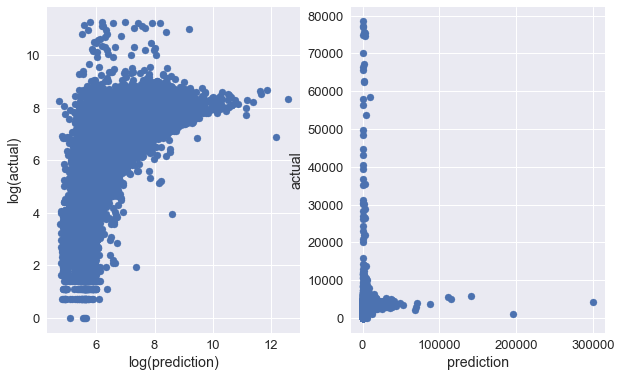

In [36]:
#plot between log transform prediction and prediction 
fig, ax = plt.subplots(ncols=2,figsize=(10,6))
ax[0].scatter(y_pred, y_test)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(actual)')
ax[1].scatter(np.exp(y_pred), np.exp(y_test))
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('actual')
plt.show()


In [37]:
#check for abnormal results
aa = np.exp(y_pred)
bb = np.exp(y_test)
cc = aa - bb
#select first 10 largest values
print (cc.nlargest(10))
cc = pd.DataFrame(cc.nlargest(20))

# abnormal_index = 488550
# print (train.loc[abnormal_index])

488550    295451.714434
487132    193975.101850
151485    135587.533538
306323    110358.284045
801814    105995.608166
717508     83862.108522
514449     67077.986758
859987     66840.684660
800750     66212.041846
9012       48817.072086
Name: trip_duration_log, dtype: float64


In [38]:
#evaluate by RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_test,y_pred):
    rmse= sqrt(mean_squared_error(y_test, y_pred))
    return rmse

print ("log transform linear regression RMSE :{}".format(rmse(y_test,y_pred)))
#convert transform log values to actual values
print ("linear regression RMSE :{}".format(rmse(np.exp(y_test), np.exp(y_pred))))

log transform linear regression RMSE :0.5059382252113306
linear regression RMSE :1009.1950656716854


## Xgboost 
Try with more complicated model

In [39]:
## fitting xgboost regression tree
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_test = xgb.DMatrix(x_test, label=y_test)

# set parameters for fitting xgboost
xgb_pars = {'min_child_weight': 80, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 20,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
            'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, xgb_train, maximize=False, verbose_eval=10)
predict = model.predict(xgb_test)

In [40]:
#rmse result for xgboost
print ("RMSE of xgboost : {}".format(rmse(y_test,predict)))

RMSE of xgboost : 0.3387479710585863


# Feature elimination from xgboost feature important result
Methods that use ensembles of decision trees like xgboost can also compute the relative importance of each attribute.
These importance values can be used to inform a feature selection process.
The given importance score for each attribute shows that the larger score the more important the attribute.

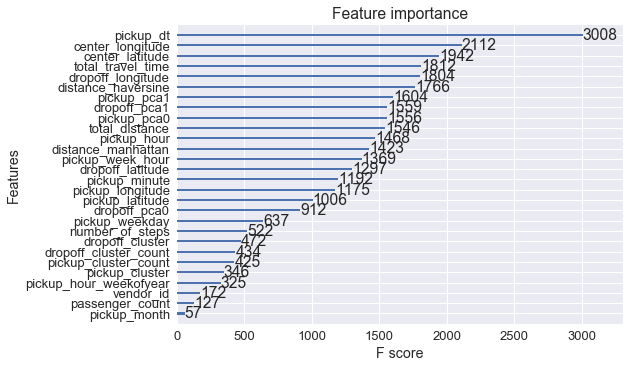

In [41]:
xgb.plot_importance(model)

### Eliminate the first and second least important features
There are some location related feature with high feature importance score, removing just some of them can be done with out increase the error.
Vendor_id is the third least used feature according to feature importance plot but removing it will increase rmse.
Trees model can use to capture its binary information well.

In [42]:
## fitting xgboost regression tree
x_train2 = x_train.drop(['store_and_fwd_flag','pickup_month','passenger_count'],axis=1)
x_test2 = x_test.drop(['store_and_fwd_flag','pickup_month','passenger_count'],axis=1)
xgb_train = xgb.DMatrix(x_train2, label=y_train)
xgb_test = xgb.DMatrix(x_test2, label=y_test)

# set parameters for fitting xgboost
xgb_pars = {'min_child_weight': 80, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 20,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
            'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, xgb_train, maximize=False, verbose_eval=10)
predict = model.predict(xgb_test)

#rmse result of xgboost after remove the first and second least important features 
print ("RMSE of xgboost after remove some features: {}".format(rmse(y_test,predict)))

RMSE of xgboost after remove some features: 0.33850590780189077


In [43]:
print ("without log RMSE of xgboost after remove some features: {}".format(rmse(np.exp(y_test),np.exp(predict))))

without log RMSE of xgboost after remove some features: 568.3015070701033


# Test set

In [51]:
x_train = train[feature_names]
y_train = train['trip_duration_log']
x_test = test[feature_names]

## fitting xgboost regression tree
x_train2 = x_train.drop(['store_and_fwd_flag','pickup_month','passenger_count'],axis=1)
x_test2 = x_test.drop(['store_and_fwd_flag','pickup_month','passenger_count'],axis=1)
xgb_train = xgb.DMatrix(x_train2, label=y_train)
xgb_test = xgb.DMatrix(x_test2, label=y_test)

# set parameters for fitting xgboost
xgb_pars = {'min_child_weight': 80, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 20,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
            'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, xgb_train, maximize=False, verbose_eval=10)
predict = model.predict(xgb_test)

In [56]:
predict_conv = pd.DataFrame(np.exp(predict),columns=['trip_duration'])
submit_df = pd.concat([test['id'],predict_conv],axis=1)

In [60]:
print (submit_df)
submit_df.to_csv("nyc_submission.csv",header=True,index=False, encoding='utf-8')

               id  trip_duration
0       id3004672     879.178833
1       id3505355     565.332336
2       id1217141     404.096680
3       id2150126    1267.925415
4       id1598245     293.996552
5       id0668992    1148.519897
6       id1765014    1376.185425
7       id0898117    1029.337646
8       id3905224    2828.051758
9       id1543102     512.276428
10      id3024712     940.878174
11      id3665810     316.674530
12      id1836461     323.961090
13      id3457080     627.427124
14      id3376065    1148.867676
15      id3008739    1045.406738
16      id0902216    1122.054077
17      id3564824     468.610596
18      id0820280     109.212914
19      id0775088    1203.183472
20      id1468488     279.967651
21      id2657479     374.361847
22      id1262719     561.420471
23      id1345524    1259.570312
24      id2911638    1102.649536
25      id2849512    1367.699951
26      id0236829     412.721405
27      id2905906     472.399933
28      id3737939    1231.717896
29      id